In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle
import h5py

In [3]:
sys.path.append("../..")

from WatChMaL.analysis.multi_plot_utils import multi_disp_learn_hist, multi_compute_roc, multi_plot_roc
from WatChMaL.analysis.comparison_utils import multi_get_masked_data, multi_collapse_test_output, collapse_test_output
from WatChMaL.analysis.fitqun_comparison_utils import load_mu_fq_output, load_pion_fq_output, load_gamma_fq_output
from WatChMaL.analysis.performance_analysis_utils import remove_indices
from WatChMaL.analysis.performance_analysis_plot_utils import plot_fitqun_binned_performance, plot_momentum_binned_performance
from WatChMaL.analysis.performance_analysis_plot_utils import plot_true_momentum_binned_performance, plot_to_wall_binned_performance, plot_energy_binned_performance, plot_zenith_binned_performance, plot_azimuth_binned_performance
from WatChMaL.analysis.performance_analysis_plot_utils import plot_to_wall_binned_in_energy, plot_zenith_binned_in_azimuth, plot_azimuth_binned_in_zenith

In [4]:
############# define plotting params #############
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
label_dict = {"$\gamma$":0, "$e$":1, "$\mu$":2, "$\pi 0$":3}
inverse_label_dict = {0:"$\gamma$", 1:"$e$", 2:"$\mu$", 3:"$\pi 0$"}
muon_softmax_index_dict = {"e/gamma":0, "mu":1}

dark_blue  = (0,0,0.5)
blue       = (0,0.8,0.8)

## Define fitqun paths

In [5]:
# Retrieve flags
gamma_file_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_gamma_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
e_file_path     = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_e-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
mu_file_path    = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_mu-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
pion_file_path  = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'

fq_mapping_path = '/home/jtindall/WatChMaL_analysis/fitqun_comparison/fitqun_comparison_prep/prep_data/4_class_3M_fitqun_mapping.pickle'

with open('./prep_data/4_class_3M_fitqun_cuts.pickle', 'rb') as handle:
    cuts = pickle.load(handle)

## Load resnet results

In [6]:
############# define run locations #############
short_locs = [#'/home/jtindall/WatChMaL/outputs/2021-04-06/13-38-38/outputs'
              '/home/jtindall/WatChMaL/outputs/2021-04-13/15-55-14/outputs', # 4 class
              '/home/jtindall/WatChMaL/outputs/2021-04-19/09-44-40/outputs'   # 2 class
              ]

short_titles = ['Short Tank (4-class)', 'Short Tank (2-class)', 'Fitqun']

full_locs = []

full_titles = []

short_linecolor = [c[0] for _ in range(2)]
short_linestyle = ['--' for _ in range(2)]

full_linecolor = [c[1] for _ in full_locs]
full_linestyle = [':' for _ in full_locs]


In [7]:
############# load short tank run data #############
short_raw_output_softmax    = [np.load(loc + "/softmax.npy") for loc in short_locs]
short_raw_actual_labels     = [np.load(loc + "/labels.npy") for loc in short_locs]

In [8]:
locs      = short_locs + full_locs
titles    = short_titles + full_titles
linecolor = short_linecolor + full_linecolor
linestyle = short_linestyle + full_linestyle

## Load h5 Data

In [9]:
# Import test events from h5 file
data_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_emgp0_E0to1000MeV_digihits.h5"
data_file = h5py.File(data_path, "r")

print(data_file.keys())

energies   = np.array(data_file['energies'])
angles     = np.array(data_file['angles'])
positions  = np.array(data_file['positions'])
labels     = np.array(data_file['labels'])

<KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


In [10]:
idxs_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_4_class_3M_emgp0_idxs.npz'
idxs = np.load(idxs_path, allow_pickle=True)

test_idxs  = idxs['test_idxs']

test_angles    = angles[test_idxs]
test_energies  = energies[test_idxs]
test_positions = positions[test_idxs]
test_labels    = labels[test_idxs]

In [11]:
print(len(test_labels))


4671749


In [12]:
1.2*4

4.8

In [13]:
d_to_wall = np.load('./prep_data/3M_d_to_wall.npz', allow_pickle=True)

test_d_to_wall  = d_to_wall['test_d_to_wall']

In [14]:
true_mom = np.load('./prep_data/3M_momenta.npz', allow_pickle=True)

test_true_mom  = true_mom['test_momenta']

## Verify Indices

In [15]:
e_gamma_4_class_idxs = np.where((test_labels == 0) | (test_labels == 1))[0]

In [16]:
print(np.bincount(short_raw_actual_labels[0]))
print(np.bincount(short_raw_actual_labels[1]))
print(np.bincount(test_labels))
print(np.bincount(test_labels[e_gamma_4_class_idxs]))

[1182377 1177966 1164139 1147267]
[1182377 1177966]
[1182377 1177966 1164139 1147267]
[1182377 1177966]


In [17]:
print(set(short_raw_actual_labels[1] - test_labels[e_gamma_4_class_idxs]))

{0}


## Generate Muon Rejection Based Preselection

### Load 4-class with muons

In [18]:
muon_softmax_index_dict = {"e/gamma":0, "mu":1}

In [19]:
muon_cut_to_apply = cuts['fq_comparison']

muon_raw_short_softmax = short_raw_output_softmax[0]

muon_filtered_short_softmax  = remove_indices(short_raw_output_softmax[0], muon_cut_to_apply)
muon_filtered_labels         = remove_indices(short_raw_actual_labels[0], muon_cut_to_apply)

muon_collapsed_class_scores, muon_collapsed_class_labels = collapse_test_output(muon_filtered_short_softmax, muon_filtered_labels, label_dict, ignore_type='$\gamma$')

muon_collapsed_class_scores = muon_collapsed_class_scores[:,1:]
muon_collapsed_class_labels = muon_collapsed_class_labels - 1 

### Compute Thresholds

In [20]:
from WatChMaL.analysis.plot_utils import compute_roc, plot_roc

In [21]:
def get_fixed_operating_cut(class_scores, labels, fpr_fixed_point):
    fprs, tprs, thrs = compute_roc(class_scores, labels, 
                                true_label=muon_softmax_index_dict["e/gamma"], 
                                false_label=muon_softmax_index_dict["mu"],
                                normalize=True)

    operating_point_thr = thrs[np.argmin(np.abs(fprs - fpr_fixed_point))]

    operating_point_cut = ((muon_raw_short_softmax[:, 0] + muon_raw_short_softmax[:, 1])/(muon_raw_short_softmax[:, 0] + muon_raw_short_softmax[:, 1] + muon_raw_short_softmax[:, 2])) < operating_point_thr

    #print(tprs[np.argmin(np.abs(fprs - fpr_fixed_point))])
    #print(fprs[np.argmin(np.abs(fprs - fpr_fixed_point))])

    return operating_point_thr, operating_point_cut

In [22]:
rej_200_operating_point_thr, rej_200_operating_point_cut = get_fixed_operating_cut(muon_collapsed_class_scores, muon_collapsed_class_labels, fpr_fixed_point=0.005)
rej_1000_operating_point_thr, rej_1000_operating_point_cut = get_fixed_operating_cut(muon_collapsed_class_scores, muon_collapsed_class_labels, fpr_fixed_point=0.001)

In [23]:
# Verify cut working
def verify_cuts(softmaxes, labels, operating_point_thr):
    comp_idxs = np.where((labels == 1 ) | (labels == 2))[0]

    scores = ((softmaxes[:, 0] + softmaxes[:, 1])/(softmaxes[:, 0] + softmaxes[:, 1] + softmaxes[:, 2]))

    pred_pos_idxs = np.where( scores[comp_idxs] >= operating_point_thr)[0]
    pred_neg_idxs = np.where( scores[comp_idxs] < operating_point_thr)[0]

    true_label, false_label = '$e$','$\mu$'
    fp = np.where(labels[comp_idxs[pred_pos_idxs]] == label_dict[false_label])[0].shape[0]
    tp = np.where(labels[comp_idxs[pred_pos_idxs]] == label_dict[true_label] )[0].shape[0]
    fn = np.where(labels[comp_idxs[pred_neg_idxs]] == label_dict[true_label] )[0].shape[0]
    tn = np.where(labels[comp_idxs[pred_neg_idxs]] == label_dict[false_label])[0].shape[0]

    # TODO: division by zero problem
    efficiency = performance = tp/(tp + fn + 1e-10)
    fpr = performance = fp/(fp + tn + 1e-10)

    print('efficiency: ' + str(efficiency) + ' | ' + 'fpr: ' + str(fpr))

In [24]:
verify_cuts(muon_filtered_short_softmax, muon_filtered_labels, operating_point_thr=rej_200_operating_point_thr)
verify_cuts(muon_filtered_short_softmax, muon_filtered_labels, operating_point_thr=rej_1000_operating_point_thr)

efficiency: 0.9848511202371382 | fpr: 0.004998335338905414
efficiency: 0.9670803893961502 | fpr: 0.0010009726843258555


## Test cut

## Plot ROC

### With muon preselection

In [25]:
def compute_preselection(scores, labels, operating_point_cut):
    cut_to_apply = cuts['fq_comparison']

    updated_cuts = np.zeros_like(test_labels, dtype=bool)
    updated_cuts[cut_to_apply] = True

    pre_muon_cuts = np.where(updated_cuts[e_gamma_4_class_idxs])[0]

    updated_cuts[operating_point_cut] = True

    cut_to_apply = np.where(updated_cuts[e_gamma_4_class_idxs])[0]

    # Compute preslection factors
    pre_muon_preselection_labels  = remove_indices(labels, pre_muon_cuts)
    post_muon_preselection_labels = remove_indices(labels, cut_to_apply)

    # Electron
    efficiency_correction_factor = len(post_muon_preselection_labels[post_muon_preselection_labels == 1]) / len(pre_muon_preselection_labels[pre_muon_preselection_labels == 1])

    print('efficiency: ', efficiency_correction_factor)

    # Gamma
    rejection_correction_factor = len(post_muon_preselection_labels[post_muon_preselection_labels == 0]) / len(pre_muon_preselection_labels[pre_muon_preselection_labels == 0])

    print('rejection: ',rejection_correction_factor)
    
    return cut_to_apply, efficiency_correction_factor, rejection_correction_factor

In [26]:
rej_200_cut_to_apply, rej_200_efficiency_correction_factor, rej_200_rejection_correction_factor = compute_preselection(short_raw_actual_labels[0][e_gamma_4_class_idxs], short_raw_actual_labels[0][e_gamma_4_class_idxs], rej_200_operating_point_cut)
rej_1000_cut_to_apply, rej_1000_efficiency_correction_factor, rej_1000_rejection_correction_factor = compute_preselection(short_raw_actual_labels[0][e_gamma_4_class_idxs], short_raw_actual_labels[0][e_gamma_4_class_idxs], rej_1000_operating_point_cut)

efficiency:  0.9848511202371384
rejection:  0.9919685869715832
efficiency:  0.9670803893961504
rejection:  0.9832893342187143


In [27]:
rej_200_muon_preselection_short_softmax   = remove_indices(short_raw_output_softmax[1], rej_200_cut_to_apply)
rej_200_muon_preselection_filtered_labels = remove_indices(short_raw_actual_labels[1], rej_200_cut_to_apply)

rej_200_fprs, rej_200_tprs, rej_200_thrs = compute_roc(rej_200_muon_preselection_short_softmax, rej_200_muon_preselection_filtered_labels, 
                            true_label=label_dict["$e$"], 
                            false_label=label_dict["$\gamma$"],
                            normalize=True)

# Update using preselection statistics
rej_200_tprs = rej_200_tprs*rej_200_efficiency_correction_factor
rej_200_fprs = rej_200_fprs*rej_200_rejection_correction_factor

In [28]:
rej_1000_muon_preselection_short_softmax   = remove_indices(short_raw_output_softmax[1], rej_1000_cut_to_apply)
rej_1000_muon_preselection_filtered_labels = remove_indices(short_raw_actual_labels[1], rej_1000_cut_to_apply)

rej_1000_fprs, rej_1000_tprs, rej_1000_thrs = compute_roc(rej_1000_muon_preselection_short_softmax, rej_1000_muon_preselection_filtered_labels, 
                            true_label=label_dict["$e$"], 
                            false_label=label_dict["$\gamma$"],
                            normalize=True)

# Update using preselection statistics
rej_1000_tprs = rej_1000_tprs*rej_1000_efficiency_correction_factor
rej_1000_fprs = rej_1000_fprs*rej_1000_rejection_correction_factor

In [29]:
fpr_list = [rej_200_fprs, rej_1000_fprs] 
tpr_list = [rej_200_tprs, rej_1000_tprs]
thr_list = [rej_200_thrs, rej_1000_thrs]

gamma_linestyle = ['--' for _ in range(4)]
gamma_linecolor = [blue, dark_blue]
gamma_titles    = ['Short Tank ResNet (2-Class), muon rejection 200', 'Short Tank ResNet (2-Class), muon rejection 1000']

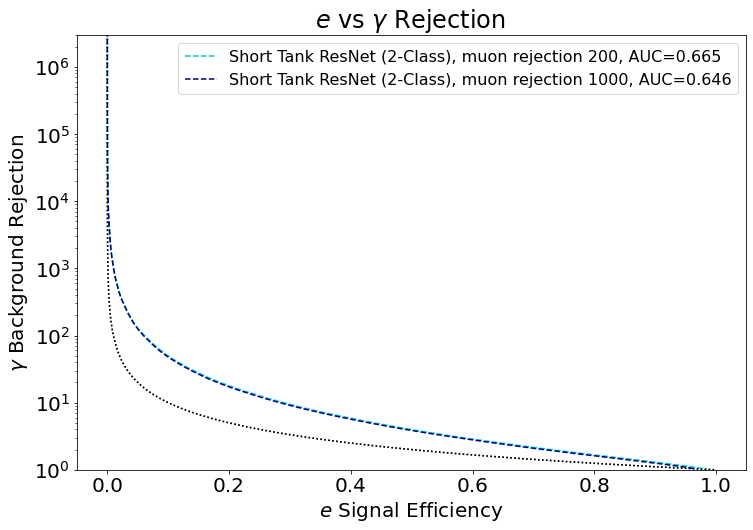

In [30]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$", 
                      fig_list=[1], ylims=[[1,3e6]], 
                      linestyles=gamma_linestyle,linecolors=gamma_linecolor, plot_labels=gamma_titles, show=False)

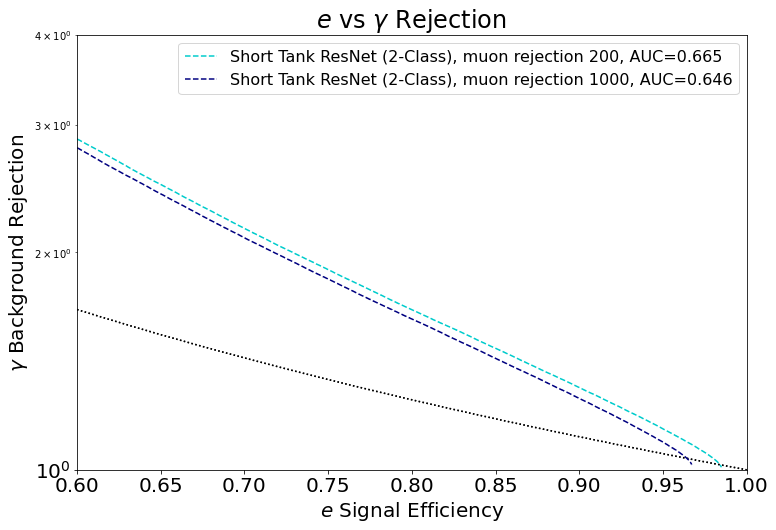

In [31]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$", 
                      fig_list=[1], xlims=[[0.6, 1.0]], ylims=[[1,4e0]], 
                      linestyles=gamma_linestyle,linecolors=gamma_linecolor, plot_labels=gamma_titles, show=False)

## Plot Performance

In [32]:
fq_scores, fq_labels, fq_mom, fq_masses = load_gamma_fq_output(fq_mapping_path, gamma_file_path, e_file_path, mu_file_path, pion_file_path, discriminator='e_v_mu')

short_output_softmax = [short_raw_output_softmax[1]] #short_raw_output_softmax[0][e_gamma_4_class_idxs], fq_scores[e_gamma_4_class_idxs]]
short_actual_labels  = [short_raw_actual_labels[1]] #[short_raw_actual_labels[0][e_gamma_4_class_idxs]] , fq_labels[e_gamma_4_class_idxs]]


In [41]:
filtered_short_softmax  = [remove_indices(short_output_softmax[0], rej_200_cut_to_apply) ,
                           remove_indices(short_output_softmax[0], rej_1000_cut_to_apply) 
                          ]
filtered_labels         = [remove_indices(short_actual_labels[0], rej_200_cut_to_apply) ,
                           remove_indices(short_actual_labels[0], rej_1000_cut_to_apply) 
                          ]

rej_200_filtered_fq_mom         = remove_indices(fq_mom[e_gamma_4_class_idxs], rej_200_cut_to_apply)
rej_200_filtered_test_energies  = remove_indices(test_energies[e_gamma_4_class_idxs], rej_200_cut_to_apply)
rej_200_filtered_test_to_wall   = remove_indices(test_d_to_wall[e_gamma_4_class_idxs], rej_200_cut_to_apply)
rej_200_filtered_test_true_mom  = remove_indices(test_true_mom[e_gamma_4_class_idxs], rej_200_cut_to_apply)
rej_200_filtered_test_energies  = remove_indices(test_energies[e_gamma_4_class_idxs], rej_200_cut_to_apply)
rej_200_filtered_test_angles    = remove_indices(test_angles[e_gamma_4_class_idxs], rej_200_cut_to_apply)
rej_200_filtered_test_zenith    = rej_200_filtered_test_angles[:, 0]
rej_200_filtered_test_azimuth   = rej_200_filtered_test_angles[:, 1]

rej_1000_filtered_fq_mom         = remove_indices(fq_mom[e_gamma_4_class_idxs], rej_1000_cut_to_apply)
rej_1000_filtered_test_energies  = remove_indices(test_energies[e_gamma_4_class_idxs], rej_1000_cut_to_apply)
rej_1000_filtered_test_to_wall   = remove_indices(test_d_to_wall[e_gamma_4_class_idxs], rej_1000_cut_to_apply)
rej_1000_filtered_test_true_mom  = remove_indices(test_true_mom[e_gamma_4_class_idxs], rej_1000_cut_to_apply)
rej_1000_filtered_test_energies  = remove_indices(test_energies[e_gamma_4_class_idxs], rej_1000_cut_to_apply)
rej_1000_filtered_test_angles    = remove_indices(test_angles[e_gamma_4_class_idxs], rej_1000_cut_to_apply)
rej_1000_filtered_test_zenith    = rej_1000_filtered_test_angles[:, 0]
rej_1000_filtered_test_azimuth   = rej_1000_filtered_test_angles[:, 1]


scores_list = [(filtered_short_softmax[0][:,1])/(filtered_short_softmax[0][:,0] + filtered_short_softmax[0][:,1]),
               (filtered_short_softmax[1][:,1])/(filtered_short_softmax[1][:,0] + filtered_short_softmax[1][:,1]),
              ]
labels_list = [filtered_labels[0], filtered_labels[1]]
names  = ['ResNet (2-class), Rejection 200', 'ResNet (2-class), Rejection 1000']
colors = [blue, dark_blue]
fpr_rate = 0.2

In [43]:
print(len(scores_list[0]))
print(len(rej_200_filtered_fq_mom))

print(len(scores_list[1]))
print(len(rej_1000_filtered_fq_mom))

1089135
1089135
1074606
1074606


<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Reconstructed Momentum At\nReconstructed Momentum Fixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Reconstructed Momentum [MeV/c]', ylabel='$e$ Signal Efficiency'>

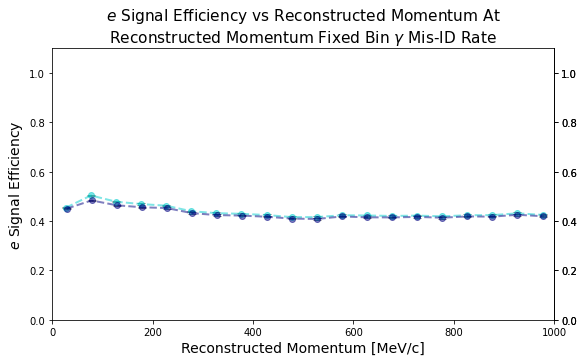

In [62]:
fig, axes = plt.subplots(1,1,figsize=(9,5), facecolor='w')

plot_momentum_binned_performance(scores_list             = [scores_list[0]], 
                                 labels_list            = [labels_list[0]],
                                 reconstructed_momentum = rej_200_filtered_test_true_mom,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 yrange                 = [0, 1.1],
                                 xrange                 = [0, 1000],
                                 names                  = [names[0]],
                                 colors                 = [colors[0]],
                                 ax                     = axes,
                                 efficiency_correction_factor = rej_200_efficiency_correction_factor, 
                                 rejection_correction_factor = rej_200_rejection_correction_factor,
                                 desired_labels=['$e$','$\gamma$'],
                                 show_legend = True
                               )

plot_momentum_binned_performance(scores_list             = [scores_list[1]], 
                                 labels_list            = [labels_list[1]],
                                 reconstructed_momentum = rej_1000_filtered_test_true_mom,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 yrange                 = [0, 1.1],
                                 xrange                 = [0, 1000],
                                 names                  = [names[1]],
                                 colors                 = [colors[1]],
                                 ax                     = axes,
                                 efficiency_correction_factor = rej_1000_efficiency_correction_factor, 
                                 rejection_correction_factor = rej_1000_rejection_correction_factor,
                                 desired_labels=['$e$','$\gamma$'],
                                 show_legend = True
                               )

<AxesSubplot:title={'center':'$\\gamma$ Mis-ID Rate vs Reconstructed Momentum At\nReconstructed Momentum Fixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Reconstructed Momentum [MeV/c]', ylabel='$\\gamma$ Mis-ID Rate'>

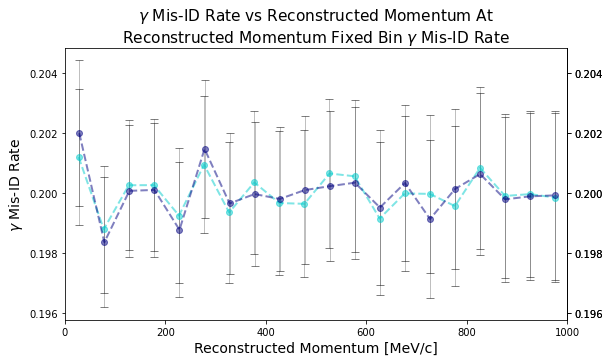

In [63]:
fig, axes = plt.subplots(1,1,figsize=(9,5), facecolor='w')

plot_momentum_binned_performance(scores_list             = [scores_list[0]], 
                                 labels_list            = [labels_list[0]],
                                 reconstructed_momentum = rej_200_filtered_test_true_mom,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 #yrange                 = [0, 0.30],
                                 xrange                 = [0, 1000],
                                 names                  = [names[0]],
                                 colors                 = [colors[0]],
                                 ax                     = axes,
                                 efficiency_correction_factor = rej_200_efficiency_correction_factor, 
                                 rejection_correction_factor = rej_200_rejection_correction_factor,
                                 desired_labels=['$e$','$\gamma$'],
                                 metric = 'fpr_rate'
                               )

plot_momentum_binned_performance(scores_list            = [scores_list[1]], 
                                 labels_list            = [labels_list[1]],
                                 reconstructed_momentum = rej_1000_filtered_test_true_mom,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 #yrange                 = [0, 0.30],
                                 xrange                 = [0, 1000],
                                 names                  = [names[1]],
                                 colors                 = [colors[1]],
                                 ax                     = axes,
                                 efficiency_correction_factor = rej_1000_efficiency_correction_factor, 
                                 rejection_correction_factor = rej_1000_rejection_correction_factor,
                                 desired_labels=['$e$','$\gamma$'],
                                 metric = 'fpr_rate'
                               )

<AxesSubplot:title={'center':'$\\gamma$ Mis-ID Rate vs Energy At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Energy [MeV/$c^2$]', ylabel='$\\gamma$ Mis-ID Rate'>

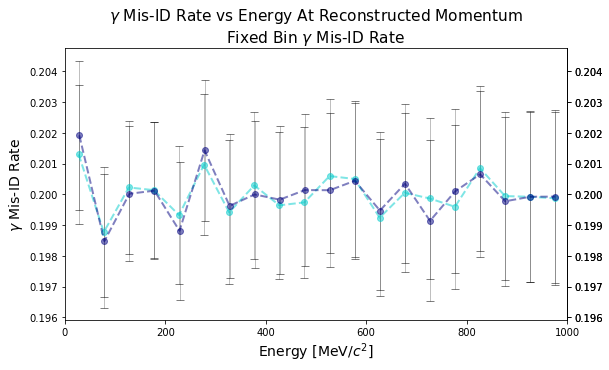

In [64]:
fig, axes = plt.subplots(1,1,figsize=(9,5), facecolor='w')

plot_energy_binned_performance(scores_list             = [scores_list[0]], 
                                 labels_list            = [labels_list[0]],
                                 reconstructed_momentum = rej_200_filtered_test_true_mom,
                                 energy_features        = rej_200_filtered_test_energies,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = [names[0]],
                                 colors                 = [colors[0]],
                                 ax                     = axes,
                                 efficiency_correction_factor = rej_200_efficiency_correction_factor, 
                                 rejection_correction_factor = rej_200_rejection_correction_factor,
                                 xrange                 = [0, 1000],
                                 desired_labels=['$e$','$\gamma$'],
                               metric = 'fpr_rate'
                               )

plot_energy_binned_performance(scores_list             = [scores_list[1]], 
                                 labels_list            = [labels_list[1]],
                                 reconstructed_momentum = rej_1000_filtered_test_true_mom,
                                 energy_features        = rej_1000_filtered_test_energies,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = [names[1]],
                                 colors                 = [colors[1]],
                                 ax                     = axes,
                                 efficiency_correction_factor = rej_1000_efficiency_correction_factor, 
                                 rejection_correction_factor = rej_1000_rejection_correction_factor,
                                 xrange                 = [0, 1000],
                                 desired_labels=['$e$','$\gamma$'],
                               metric = 'fpr_rate'
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs To Wall At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='To Wall [cm]', ylabel='$e$ Signal Efficiency'>

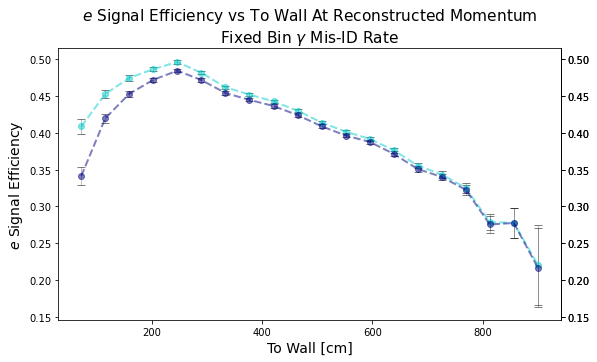

In [65]:
fig, axes = plt.subplots(1,1,figsize=(9,5), facecolor='w')


plot_to_wall_binned_performance(scores_list             = [scores_list[0]], 
                                 labels_list            = [labels_list[0]],
                                 reconstructed_momentum = rej_200_filtered_test_true_mom,
                                 to_wall_features       = rej_200_filtered_test_to_wall,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = [names[0]],
                                 colors                 = [colors[0]],
                                 ax                     = axes,
                                 efficiency_correction_factor = rej_200_efficiency_correction_factor, 
                                 rejection_correction_factor = rej_200_rejection_correction_factor,
                                 desired_labels=['$e$','$\gamma$']
                               )

plot_to_wall_binned_performance(scores_list             = [scores_list[1]], 
                                 labels_list            = [labels_list[1]],
                                 reconstructed_momentum = rej_1000_filtered_test_true_mom,
                                 to_wall_features       = rej_1000_filtered_test_to_wall,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = [names[1]],
                                 colors                 = [colors[1]],
                                 ax                     = axes,
                                 efficiency_correction_factor = rej_1000_efficiency_correction_factor, 
                                 rejection_correction_factor = rej_1000_rejection_correction_factor,
                                 desired_labels=['$e$','$\gamma$']
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Zenith At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Zenith [Radians]', ylabel='$e$ Signal Efficiency'>

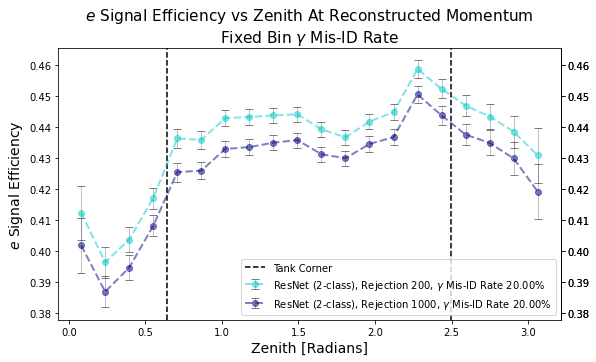

In [66]:
fig, axes = plt.subplots(1,1,figsize=(9,5), facecolor='w')

plot_zenith_binned_performance(scores_list             = [scores_list[0]], 
                                 labels_list            = [labels_list[0]],
                                 reconstructed_momentum = rej_200_filtered_test_true_mom,
                                 zenith_features        = rej_200_filtered_test_zenith,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = [names[0]],
                                 colors                 = [colors[0]],
                                 ax                     = axes,
                                 efficiency_correction_factor = rej_200_efficiency_correction_factor, 
                                 rejection_correction_factor = rej_200_rejection_correction_factor,
                                 desired_labels         = ['$e$','$\gamma$']
                               )

plot_zenith_binned_performance(scores_list             = [scores_list[1]], 
                                 labels_list            = [labels_list[1]],
                                 reconstructed_momentum = rej_1000_filtered_test_true_mom,
                                 zenith_features        = rej_1000_filtered_test_zenith,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = [names[1]],
                                 colors                 = [colors[1]],
                                 ax                     = axes,
                                 efficiency_correction_factor = rej_1000_efficiency_correction_factor, 
                                 rejection_correction_factor = rej_1000_rejection_correction_factor,
                                 desired_labels         = ['$e$','$\gamma$']
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$e$ Signal Efficiency'>

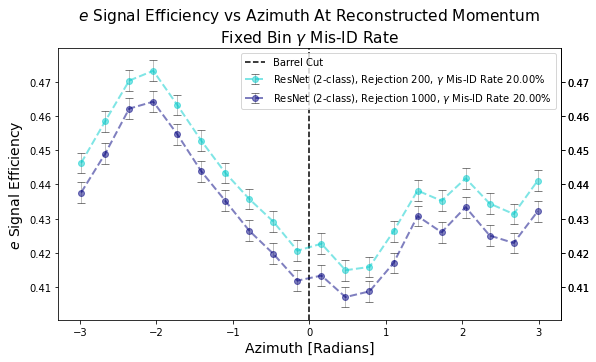

In [67]:
fig, axes = plt.subplots(1,1,figsize=(9,5), facecolor='w')


plot_azimuth_binned_performance(scores_list             = [scores_list[0]], 
                                 labels_list            = [labels_list[0]],
                                 reconstructed_momentum = rej_200_filtered_test_true_mom,
                                 azimuth_features       = rej_200_filtered_test_azimuth,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = [names[0]],
                                 colors                 = [colors[0]],
                                 ax                     = axes,
                                 efficiency_correction_factor = rej_200_efficiency_correction_factor, 
                                 rejection_correction_factor = rej_200_rejection_correction_factor,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 #yrange                 = [0.57, 0.73]
                               )

plot_azimuth_binned_performance(scores_list             = [scores_list[1]], 
                                 labels_list            = [labels_list[1]],
                                 reconstructed_momentum = rej_1000_filtered_test_true_mom,
                                 azimuth_features       = rej_1000_filtered_test_azimuth,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = [names[1]],
                                 colors                 = [colors[1]],
                                 ax                     = axes,
                                 efficiency_correction_factor = rej_1000_efficiency_correction_factor, 
                                 rejection_correction_factor = rej_1000_rejection_correction_factor,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 #yrange                 = [0.57, 0.73]
                               )

## Multiple Variable Plotting

In [ ]:
plot_to_wall_binned_in_energy(scores_list            = scores_list, 
                              labels_list            = labels_list,
                              reconstructed_momentum = filtered_fq_mom,
                              binning_features       = filtered_test_energies,
                              binning_bin_size       = 200,
                              to_wall_features       = filtered_test_to_wall,
                              fpr_fixed_point        = fpr_rate, 
                              index_dict             = label_dict, 
                              recons_mom_bin_size    = 50, 
                              plot_bins              = 10,
                              names                  = names,
                              colors                 = colors,
                              desired_labels         = ['$e$','$\gamma$']
                              )

In [ ]:
plot_azimuth_binned_in_zenith(scores_list                = scores_list, 
                                  labels_list            = labels_list,
                                  reconstructed_momentum = filtered_fq_mom,
                                  binning_features       = filtered_test_zenith,
                                  binning_bin_size       = 0.5,
                                  azimuth_features       = filtered_test_azimuth,
                                  fpr_fixed_point        = fpr_rate, 
                                  index_dict             = label_dict, 
                                  recons_mom_bin_size    = 50, 
                                  plot_bins              = 10,
                                  names                  = names,
                                  colors                 = colors,
                                  desired_labels         = ['$e$','$\gamma$']
                                  )

In [ ]:
plot_zenith_binned_in_azimuth(scores_list                = scores_list, 
                                  labels_list            = labels_list,
                                  reconstructed_momentum = filtered_fq_mom,
                                  binning_features       = filtered_test_azimuth,
                                  binning_bin_size       = 0.5,
                                  zenith_features        = filtered_test_zenith,
                                  fpr_fixed_point        = fpr_rate, 
                                  index_dict             = label_dict, 
                                  recons_mom_bin_size    = 50, 
                                  plot_bins              = 10,
                                  names                  = names,
                                  colors                 = colors,
                                  desired_labels         = ['$e$','$\gamma$'] 
                                  )

## 2D hist

In [ ]:
from WatChMaL.analysis.performance_analysis_plot_utils import  plot_2D_hist

In [ ]:
plot_2D_hist(scores_list                = scores_list, 
             labels_list            = labels_list,
             reconstructed_momentum = filtered_fq_mom,
             binning_features       = filtered_test_zenith,
             binning_bins           = 20,
             plot_binning_features  = filtered_test_azimuth,
             fpr_fixed_point        = fpr_rate, 
             index_dict             = label_dict, 
             recons_mom_bin_size    = 50, 
             plot_bins              = 20,
             names                  = names,
             colors                 = colors,
             desired_labels         = ['$e$','$\gamma$']
             )